In [14]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random

from models.lstm import LSTMRegressor
from models.kan_encoder import KANEncoder
from utils.stock_data import get_data_loaders, StockIndex
from utils.early_stopping import EarlyStopping
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [15]:
window_size = 7
SEED=42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

BEST_LSTM_PARAMS = {
    StockIndex.NVDA: {
        "hidden_dim": 352,
        "num_layers": 1,
        "dropout": 0.28541614143129757,
        "batch_size": 16,
        "lr": 0.00044517259602202056
    },
    StockIndex.AAPL: {
        "hidden_dim": 384,
        "num_layers": 1,
        "dropout": 0.22917171281782978,
        "batch_size": 16,
        "lr": 0.0026358901455780454
    },
    StockIndex.KO: {
        "hidden_dim": 480,
        "num_layers": 1,
        "dropout": 0.19466720673124002,
        "batch_size": 16,
        "lr": 0.0014651429936464527
    }
}

BEST_KAN_PARAMS = {
    StockIndex.NVDA: {
        "kan_hidden_dim": 8,
        "grid": 9,
        "k": 4,
        "lambda_reg": 0.0001755497904205043,
        "lamb_entropy": 0.2890273244582424,
        "lamb_l1": 1.646655470167218,
        "lr": 0.00023052481262803367
    },
    StockIndex.AAPL: {
        "kan_hidden_dim": 8,
        "grid": 21,
        "k": 2,
        "lambda_reg": 0.00011329515717103127,
        "lamb_entropy": 0.8637713706461654,
        "lamb_l1": 1.7398984779905824,
        "lr": 0.005440281738406265
    },
    StockIndex.KO: {
        "kan_hidden_dim": 8,
        "grid": 7,
        "k": 3,
        "lambda_reg": 0.0019182942315179368,
        "lamb_entropy": 0.17547544642119933,
        "lamb_l1": 0.338808735570516,
        "lr": 0.006010391558030342
    }
}

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Training KAN-Fixed LSTM for each stock ##

### NVDIA ###
Avg Val Loss in Tuning 0.004226

In [16]:
stock = StockIndex.NVDA
lstm_params = BEST_LSTM_PARAMS[stock]
kan_params = BEST_KAN_PARAMS[stock]
train_dl, test_dl, scalers = get_data_loaders(stock, window_size, batch_size = lstm_params["batch_size"],
                                                      use_val_split=False)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train=0.017094936980301456
Epoch 2: Train=0.0006536764834744085
Epoch 3: Train=0.0005208409738678702
Epoch 4: Train=0.0004875165051098612
Epoch 5: Train=0.00033936499683550947
Epoch 6: Train=0.00034919462139974583
Epoch 7: Train=0.00044446778463110367
Epoch 8: Train=0.00030305399103772195
Epoch 9: Train=0.00033703829169760206
Epoch 10: Train=0.00027142774137007446
Epoch 11: Train=0.00023910384334158152
Epoch 12: Train=0.00032966301851139186
Epoch 13: Train=0.00024642227726137135
Epoch 14: Train=0.0003617001040968009
Epoch 15: Train=0.0002727362248748764
Epoch 16: Train=0.00030501616555454227
Epoch 17: Train=0.0002681503975334709
Epoch 18: Train=0.0002501797335762695
Epoch 19: Train=0.00027364494003863496
Epoch 20: Train=0.0003956007331182282


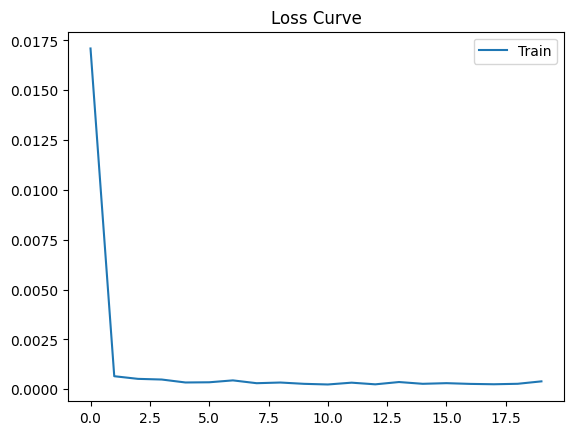

In [17]:
nvda_lstm = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

nvda_encoder = KANEncoder(
    width=[input_dim, kan_params['kan_hidden_dim'], input_dim],
    grid=kan_params['grid'],
    k=kan_params['k'],
    symbolic_enabled=False,
    affine_trainable=True,
    device=device,
    seed=SEED
).to(device)

optimizer = optim.Adam([
        {'params': nvda_encoder.parameters(), 'lr': kan_params['lr']},
        {'params': nvda_lstm.parameters(), 'lr': lstm_params['lr']}
    ])
criterion = nn.MSELoss()
train_losses = []

for epoch in range(20):
    nvda_encoder.train()
    nvda_lstm.train()
    train_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = nvda_encoder(xb)
        preds = nvda_lstm(encoded).squeeze()
        mse_loss = criterion(preds, yb)

        reg = nvda_encoder.kan.get_reg(
            reg_metric="edge_forward_spline_n",
            lamb_l1=kan_params['lamb_l1'],
            lamb_entropy=kan_params['lamb_entropy'],
            lamb_coef=0.0,
            lamb_coefdiff=0.0
        )
        train_loss += mse_loss.item()
        total_loss = mse_loss + kan_params['lambda_reg'] * reg
        total_loss.backward()
        optimizer.step()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}: Train={train_loss}")#: Val={val_loss}")

plt.plot(train_losses, label='Train')
# plt.plot(val_losses, label='Val')
plt.legend()
plt.title("Loss Curve")
plt.show()

Test RMSE: 12.4997
Test MAE : 10.2633


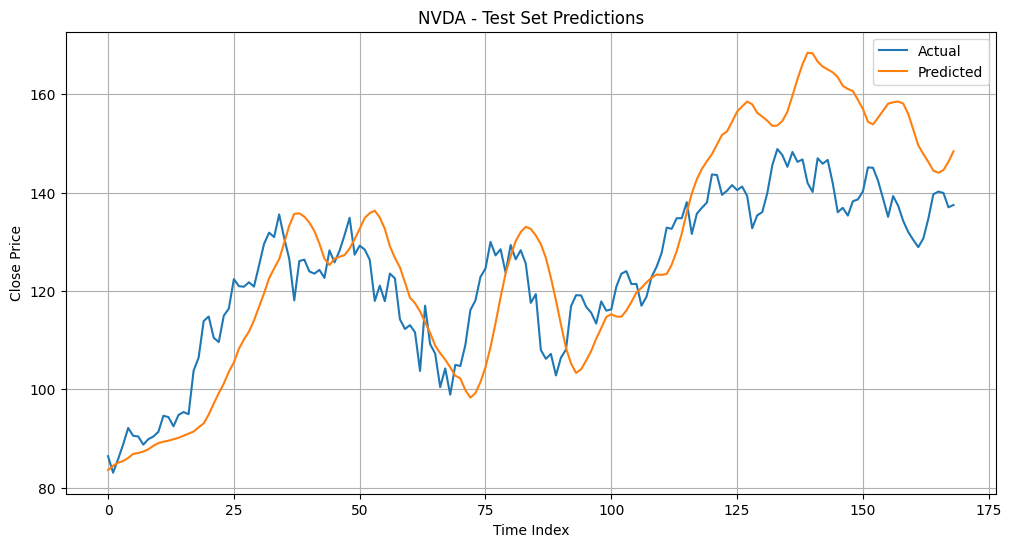

Actual Volatility (std of returns): 0.0328
Predicted Volatility             : 0.0166


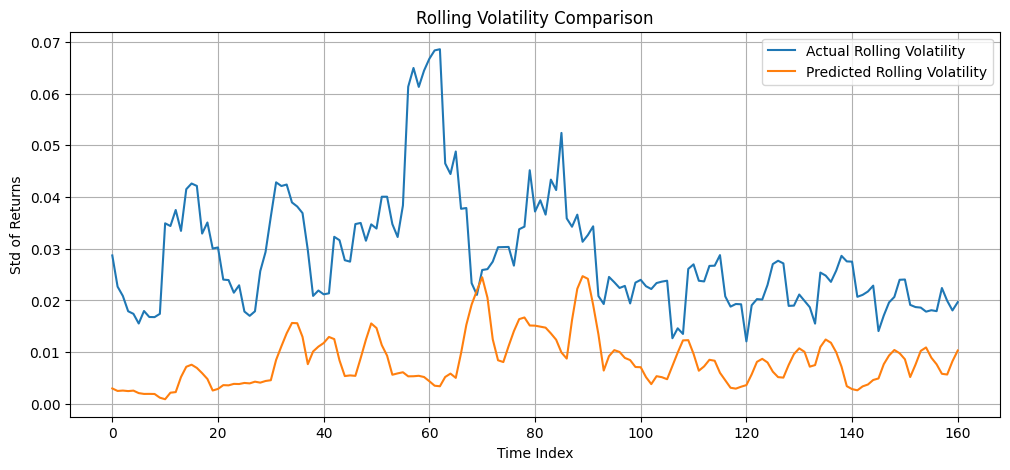

In [18]:
# Ensure both models are in eval mode
nvda_encoder.eval()
nvda_lstm.eval()

preds, targets = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        encoded = nvda_encoder(xb)             # [B, T, D]
        pred = nvda_lstm(encoded).squeeze().cpu().numpy()
        preds.extend(pred)
        targets.extend(yb.numpy())

# Unscale predictions if needed
close_scaler = scalers[f"{stock.value}_Close"]
nvda_preds_unscaled = close_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
nvda_targets_unscaled = close_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

# Compute error metrics
rmse = np.sqrt(mean_squared_error(nvda_targets_unscaled, nvda_preds_unscaled))
mae = mean_absolute_error(nvda_targets_unscaled, nvda_preds_unscaled)

# Print metrics
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(nvda_targets_unscaled, label="Actual")
plt.plot(nvda_preds_unscaled, label="Predicted")
plt.legend()
plt.title(f"{stock.value} - Test Set Predictions")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

actual_returns = np.diff(nvda_targets_unscaled) / nvda_targets_unscaled[:-1]
pred_returns   = np.diff(nvda_preds_unscaled) / nvda_preds_unscaled[:-1]
actual_vol = np.std(actual_returns)
pred_vol   = np.std(pred_returns)

print(f"Actual Volatility (std of returns): {actual_vol:.4f}")
print(f"Predicted Volatility             : {pred_vol:.4f}")

window = 7  # rolling window in days

actual_vol_rolling = np.std([
    actual_returns[i:i+window] for i in range(len(actual_returns) - window)
], axis=1)

pred_vol_rolling = np.std([
    pred_returns[i:i+window] for i in range(len(pred_returns) - window)
], axis=1)

plt.figure(figsize=(12, 5))
plt.plot(actual_vol_rolling, label='Actual Rolling Volatility')
plt.plot(pred_vol_rolling, label='Predicted Rolling Volatility')
plt.title("Rolling Volatility Comparison")
plt.xlabel("Time Index")
plt.ylabel("Std of Returns")
plt.legend()
plt.grid(True)
plt.show()

### Apple ###
Avg Val Loss in Tuning 0.000305

In [8]:
stock = StockIndex.AAPL
lstm_params = BEST_LSTM_PARAMS[stock]
kan_params = BEST_KAN_PARAMS[stock]
train_dl, test_dl, scalers = get_data_loaders(stock, window_size, batch_size = lstm_params["batch_size"],
                                                      use_val_split=False)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train=0.021305107631229073
Epoch 2: Train=0.0005036246462494624
Epoch 3: Train=0.00046191974553324265
Epoch 4: Train=0.0007224474513828001
Epoch 5: Train=0.0005966510950450108
Epoch 6: Train=0.0005790424749115247
Epoch 7: Train=0.0005305427368530401
Epoch 8: Train=0.0005215717627457578
Epoch 9: Train=0.0005317614966476655
Epoch 10: Train=0.0007565763234831111
Epoch 11: Train=0.0004574848111716541
Epoch 12: Train=0.0005519277934453008
Epoch 13: Train=0.000382354885096911
Epoch 14: Train=0.0003241412086568707
Epoch 15: Train=0.00042478689033716843
Epoch 16: Train=0.0005734434674406951
Epoch 17: Train=0.00031048416749767093
Epoch 18: Train=0.000580887927781353
Epoch 19: Train=0.00030911982284665974
Epoch 20: Train=0.0003654507952042611
Epoch 21: Train=0.0004060500904957698
Epoch 22: Train=0.00027551801156163255
Epoch 23: Train=0.00028935376604115873
Epoch 24: Train=0.00033336811780699084
Epoch 25: Train=0.0003472666514169006
Epoch 26: Train=0.00045065746323388976
Epoch 27: Train=

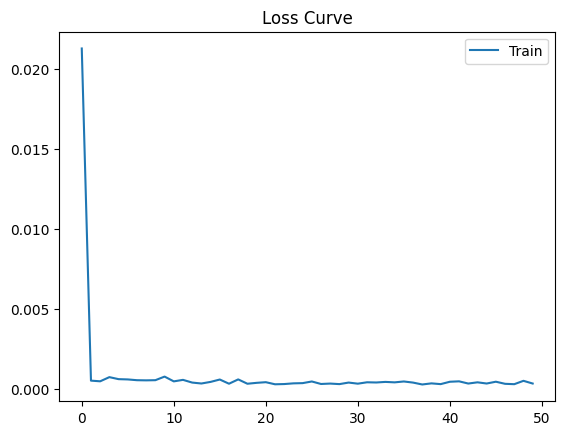

In [9]:
aapl_lstm = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

aapl_encoder = KANEncoder(
    width=[input_dim, kan_params['kan_hidden_dim'], input_dim],
    grid=kan_params['grid'],
    k=kan_params['k'],
    symbolic_enabled=False,
    affine_trainable=True,
    device=device,
    seed=SEED
).to(device)

optimizer = optim.Adam([
        {'params': aapl_encoder.parameters(), 'lr': kan_params['lr']},
        {'params': aapl_lstm.parameters(), 'lr': lstm_params['lr']}
    ])
criterion = nn.MSELoss()
train_losses = []

for epoch in range(50):
    aapl_encoder.train()
    aapl_lstm.train()
    train_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = aapl_encoder(xb)
        preds = aapl_lstm(encoded).squeeze()
        mse_loss = criterion(preds, yb)

        reg = aapl_encoder.kan.get_reg(
            reg_metric="edge_forward_spline_n",
            lamb_l1=kan_params['lamb_l1'],
            lamb_entropy=kan_params['lamb_entropy'],
            lamb_coef=0.0,
            lamb_coefdiff=0.0
        )
        train_loss += mse_loss.item()
        total_loss = mse_loss + kan_params['lambda_reg'] * reg
        total_loss.backward()
        optimizer.step()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}: Train={train_loss}")#: Val={val_loss}")

plt.plot(train_losses, label='Train')
# plt.plot(val_losses, label='Val')
plt.legend()
plt.title("Loss Curve")
plt.show()

Test RMSE: 40.3538
Test MAE : 36.7867


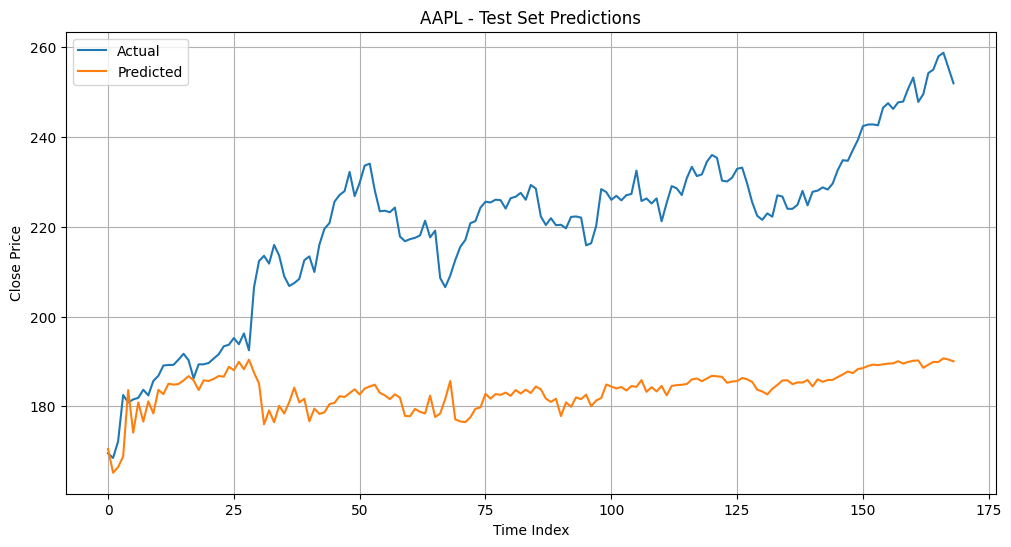

Actual Volatility (std of returns): 0.0145
Predicted Volatility             : 0.0136


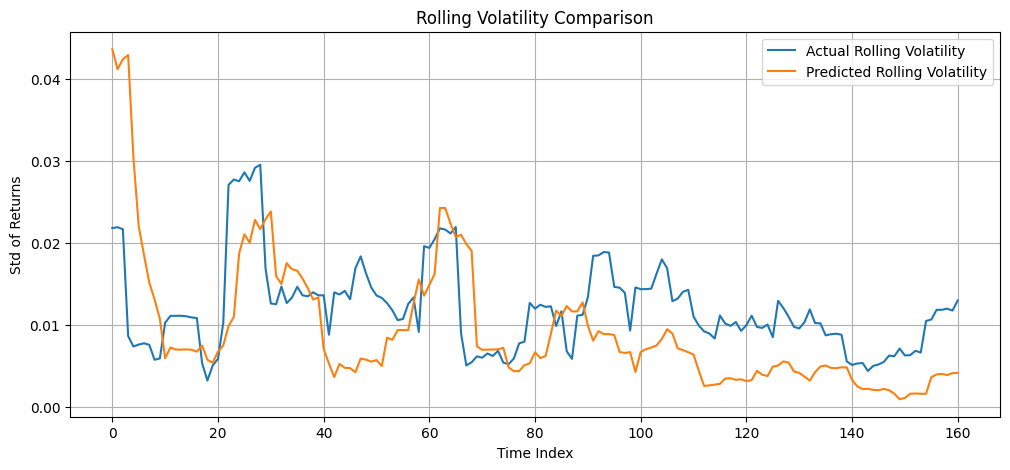

In [10]:
# Ensure both models are in eval mode
aapl_encoder.eval()
aapl_lstm.eval()

preds, targets = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        encoded = aapl_encoder(xb)             # [B, T, D]
        pred = aapl_lstm(encoded).squeeze().cpu().numpy()
        preds.extend(pred)
        targets.extend(yb.numpy())

# Unscale predictions if needed
close_scaler = scalers[f"{stock.value}_Close"]
aapl_preds_unscaled = close_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
aapl_targets_unscaled = close_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

# Compute error metrics
rmse = np.sqrt(mean_squared_error(aapl_targets_unscaled, aapl_preds_unscaled))
mae = mean_absolute_error(aapl_targets_unscaled, aapl_preds_unscaled)

# Print metrics
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(aapl_targets_unscaled, label="Actual")
plt.plot(aapl_preds_unscaled, label="Predicted")
plt.legend()
plt.title(f"{stock.value} - Test Set Predictions")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

actual_returns = np.diff(aapl_targets_unscaled) / aapl_targets_unscaled[:-1]
pred_returns   = np.diff(aapl_preds_unscaled) / aapl_preds_unscaled[:-1]
actual_vol = np.std(actual_returns)
pred_vol   = np.std(pred_returns)

print(f"Actual Volatility (std of returns): {actual_vol:.4f}")
print(f"Predicted Volatility             : {pred_vol:.4f}")

window = 7  # rolling window in days

actual_vol_rolling = np.std([
    actual_returns[i:i+window] for i in range(len(actual_returns) - window)
], axis=1)

pred_vol_rolling = np.std([
    pred_returns[i:i+window] for i in range(len(pred_returns) - window)
], axis=1)

plt.figure(figsize=(12, 5))
plt.plot(actual_vol_rolling, label='Actual Rolling Volatility')
plt.plot(pred_vol_rolling, label='Predicted Rolling Volatility')
plt.title("Rolling Volatility Comparison")
plt.xlabel("Time Index")
plt.ylabel("Std of Returns")
plt.legend()
plt.grid(True)
plt.show()

### Coke ###
Avg Val Loss in Tuning 0.000370

In [11]:
stock = StockIndex.KO
lstm_params = BEST_LSTM_PARAMS[stock]
kan_params = BEST_KAN_PARAMS[stock]
train_dl, test_dl, scalers = get_data_loaders(stock, window_size, batch_size = lstm_params["batch_size"],
                                                      use_val_split=False)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train=0.04730492609146173
Epoch 2: Train=0.001632739677484326
Epoch 3: Train=0.0021167641653763976
Epoch 4: Train=0.00128174388109156
Epoch 5: Train=0.0013077389642906685
Epoch 6: Train=0.0013773472758593283
Epoch 7: Train=0.0016411363889199842
Epoch 8: Train=0.0010350221587813017
Epoch 9: Train=0.0009498641001015921
Epoch 10: Train=0.0009812569945951868
Epoch 11: Train=0.0008765862198697045
Epoch 12: Train=0.0011473364129690735
Epoch 13: Train=0.0011550265078014233
Epoch 14: Train=0.0008770446764890838
Epoch 15: Train=0.0007562007331124724
Epoch 16: Train=0.0006770563699631961
Epoch 17: Train=0.0006223147346360628
Epoch 18: Train=0.0006666559469650942
Epoch 19: Train=0.000642842182335726
Epoch 20: Train=0.0006373885243183303
Epoch 21: Train=0.0010658851871737326
Epoch 22: Train=0.0006478808297260637
Epoch 23: Train=0.0007360231410888391
Epoch 24: Train=0.0006009274802636355
Epoch 25: Train=0.0009127337091033243
Epoch 26: Train=0.000648655646599387
Epoch 27: Train=0.0006009310

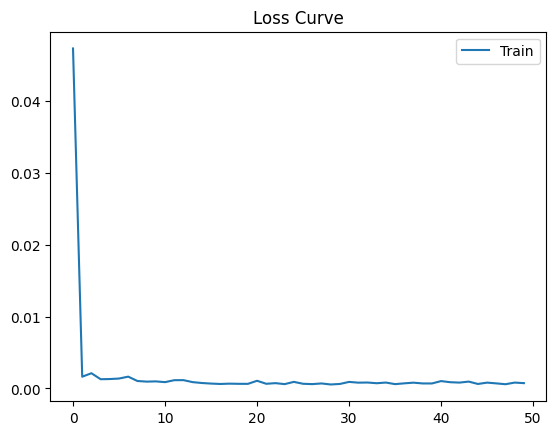

In [12]:
ko_lstm = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

ko_encoder = KANEncoder(
    width=[input_dim, kan_params['kan_hidden_dim'], input_dim],
    grid=kan_params['grid'],
    k=kan_params['k'],
    symbolic_enabled=False,
    affine_trainable=True,
    device=device,
    seed=SEED
).to(device)

optimizer = optim.Adam([
        {'params': ko_encoder.parameters(), 'lr': kan_params['lr']},
        {'params': ko_lstm.parameters(), 'lr': lstm_params['lr']}
    ])
criterion = nn.MSELoss()
train_losses = []
val_losses = []

best_val_loss = float("inf")
best_model_state = None

for epoch in range(50):
    ko_encoder.train()
    ko_lstm.train()
    train_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = ko_encoder(xb)
        preds = ko_lstm(encoded).squeeze()
        mse_loss = criterion(preds, yb)

        reg = ko_encoder.kan.get_reg(
            reg_metric="edge_forward_spline_n",
            lamb_l1=kan_params['lamb_l1'],
            lamb_entropy=kan_params['lamb_entropy'],
            lamb_coef=0.0,
            lamb_coefdiff=0.0
        )
        train_loss += mse_loss.item()
        total_loss = mse_loss + kan_params['lambda_reg'] * reg
        total_loss.backward()
        optimizer.step()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}: Train={train_loss}")#: Val={val_loss}")

plt.plot(train_losses, label='Train')
# plt.plot(val_losses, label='Val')
plt.legend()
plt.title("Loss Curve")
plt.show()

Test RMSE: 6.6276
Test MAE : 5.5950


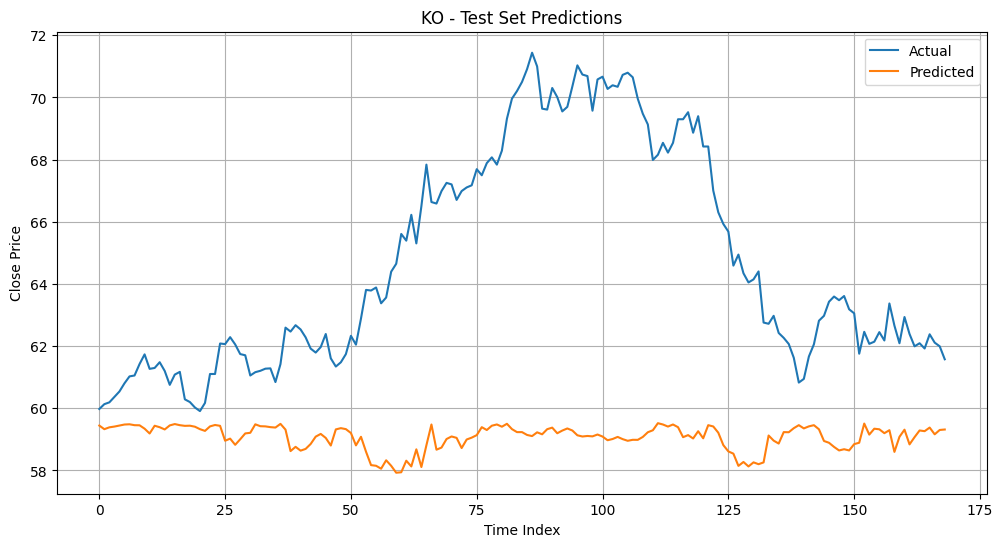

Actual Volatility (std of returns): 0.0083
Predicted Volatility             : 0.0040


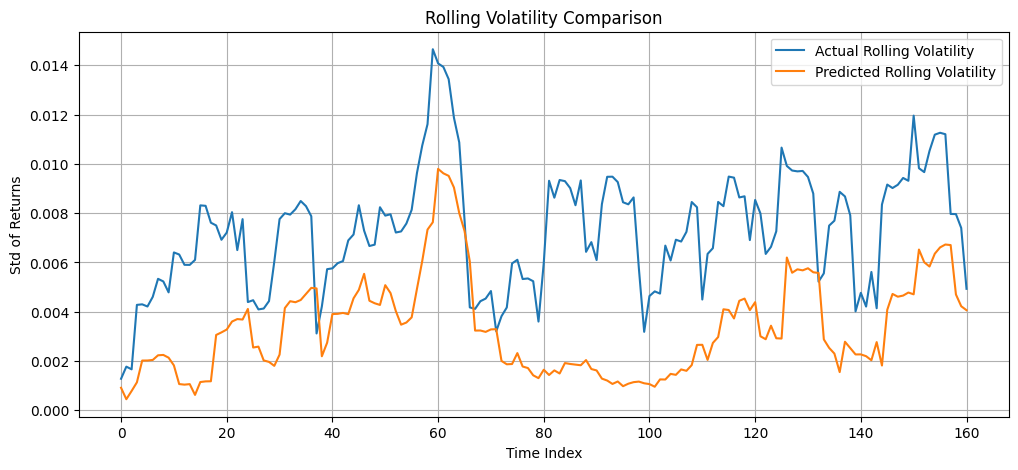

In [13]:
# Ensure both models are in eval mode
ko_encoder.eval()
ko_lstm.eval()

preds, targets = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        encoded = ko_encoder(xb)             # [B, T, D]
        pred = ko_lstm(encoded).squeeze().cpu().numpy()
        preds.extend(pred)
        targets.extend(yb.numpy())

# Unscale predictions if needed
close_scaler = scalers[f"{stock.value}_Close"]
ko_preds_unscaled = close_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
ko_targets_unscaled = close_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

# Compute error metrics
rmse = np.sqrt(mean_squared_error(ko_targets_unscaled, ko_preds_unscaled))
mae = mean_absolute_error(ko_targets_unscaled, ko_preds_unscaled)

# Print metrics
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(ko_targets_unscaled, label="Actual")
plt.plot(ko_preds_unscaled, label="Predicted")
plt.legend()
plt.title(f"{stock.value} - Test Set Predictions")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

actual_returns = np.diff(ko_targets_unscaled) / ko_targets_unscaled[:-1]
pred_returns   = np.diff(ko_preds_unscaled) / ko_preds_unscaled[:-1]
actual_vol = np.std(actual_returns)
pred_vol   = np.std(pred_returns)

print(f"Actual Volatility (std of returns): {actual_vol:.4f}")
print(f"Predicted Volatility             : {pred_vol:.4f}")

window = 7  # rolling window in days

actual_vol_rolling = np.std([
    actual_returns[i:i+window] for i in range(len(actual_returns) - window)
], axis=1)

pred_vol_rolling = np.std([
    pred_returns[i:i+window] for i in range(len(pred_returns) - window)
], axis=1)

plt.figure(figsize=(12, 5))
plt.plot(actual_vol_rolling, label='Actual Rolling Volatility')
plt.plot(pred_vol_rolling, label='Predicted Rolling Volatility')
plt.title("Rolling Volatility Comparison")
plt.xlabel("Time Index")
plt.ylabel("Std of Returns")
plt.legend()
plt.grid(True)
plt.show()